In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from pyomo.environ import *
from optimization_utils import *
from param_loader import METANET_Params
from simulation_utils import *

In [2]:
# print ipopt version
!ipopt --version

Ipopt 3.14.16 (Darwin x86_64), ASL(20160307)


In [3]:
# rho_hat = df["Density"]
# q_hat = df["Flow"]
# print(max(q_hat))
# C_i = np.mean(sorted(q_hat)[-5:])
# print("C_i", C_i)
# K = len(rho_hat)

q_hat = np.load("data/flow_10sec_400m_1hr.npy")
print(np.max(q_hat))
rho_hat = np.load("data/density_10sec_400m_1hr.npy")
v_hat = q_hat / rho_hat
print(rho_hat.shape)
flattened_q_hat = q_hat.flatten()
print(max(flattened_q_hat))
flattened_rho_hat = rho_hat.flatten()
C_i = np.mean(np.sort(flattened_q_hat)[-5:])
print("C_i", C_i)
K = len(flattened_rho_hat)
print("K", K)

6773.200199999966
(360, 16)
6773.200199999966
C_i 6718.716719999977
K 5760


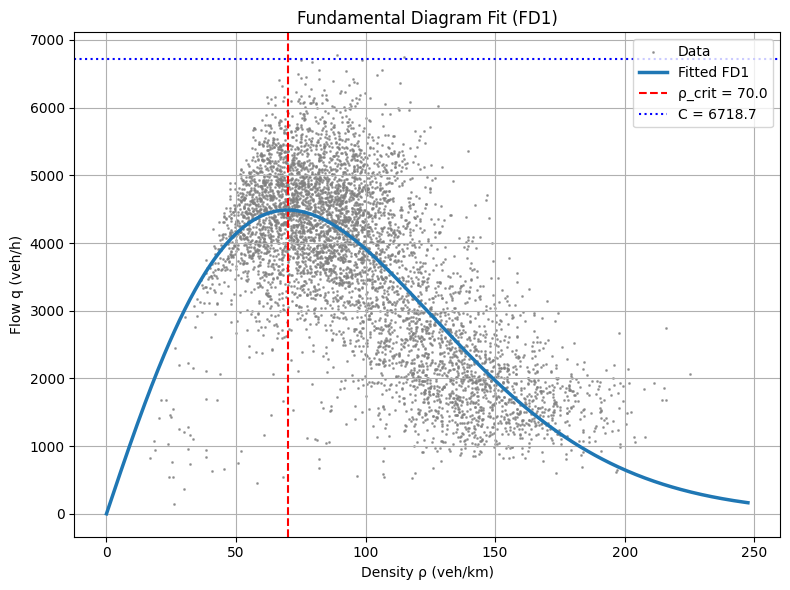

{'rho_crit': 69.95774856112287, 'V_free': 114.25733457721735, 'a': 1.7319895914943968, 'C': np.float64(6718.716719999977), 'Q_fd1': <function fit_fd1.<locals>.Q_fd1 at 0x1214d4eb0>}


In [4]:
params = fit_fd1(flattened_rho_hat, flattened_q_hat)
print(params)

In [5]:
rho_hat = np.where(rho_hat == 0.0, 1e-3, rho_hat)
q_hat = np.where(q_hat == 0.0, 1e-3, q_hat)
# v_hat = q_hat / rho_hat
# v_hat = np.where(v_hat == 0.0, 1e-3, v_hat)

In [6]:
random.seed(1)
np.random.seed(1)

T = 10 / 3600
l = 0.4
num_calibrated_segments = 14
include_ramping = False
varylanes = False
# lane_mapping = np.array([4 if i < num_calibrated_segments - 4 else 2 for i in range(num_calibrated_segments)])
RESULTS_DIR = "calibration_results"

results = run_calibration(
    rho_hat,
    q_hat,
    T,
    l,
    num_calibrated_segments=num_calibrated_segments,
    varylanes=varylanes,
    include_ramping=include_ramping,
    smoothing=True
)

1 15
360 14
(360, 1)
(360, 1)
Ipopt 3.14.16: max_iter=20000
acceptable_constr_viol_tol=1e-12
constr_viol_tol=1e-12


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    79008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    78859

Total number of variables............................:    15204
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    15204
                     variables with only

In [7]:
# Save initial and downstream conditions
import os
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
np.save(f"{RESULTS_DIR}/upstream_flow.npy", q_hat[:, 0])
np.save(f"{RESULTS_DIR}/downstream_density.npy", rho_hat[:, -1])

In [8]:
tau_array = results["tau"]
K_array = results["K"]
eta_high_array = results["eta_high"]
rho_crit_array = results["rho_crit"]
v_free_array = results["v_free"]
a_array = results["a"]
num_lanes_array = results["num_lanes"]
# if include_ramping:
    # gamma_array = results["gamma"]
beta_array = results["beta"]
r_inflow_array = results["r_inflow"]

In [9]:
# r_array = np.zeros(num_calibrated_segments)
# beta_array = np.zeros(num_calibrated_segments)
# print(beta_array.shape)
# print(r_inflow_array.shape)

In [10]:
# Save everything
v_pred_array = results["v_pred"]
rho_pred_array = results["rho_pred"]
q_array = v_pred_array * rho_pred_array
np.save(f"{RESULTS_DIR}/tau.npy", tau_array)
np.save(f"{RESULTS_DIR}/K.npy", K_array)
np.save(f"{RESULTS_DIR}/eta_high.npy", eta_high_array)
np.save(f"{RESULTS_DIR}/rho_crit.npy", rho_crit_array)
np.save(f"{RESULTS_DIR}/v_free.npy", v_free_array)
np.save(f"{RESULTS_DIR}/a.npy", a_array)
np.save(f"{RESULTS_DIR}/num_lanes.npy", num_lanes_array)
np.save(f"{RESULTS_DIR}/q_pred.npy", q_array)
np.save(f"{RESULTS_DIR}/v_pred.npy", v_pred_array)
np.save(f"{RESULTS_DIR}/rho_pred.npy", rho_pred_array)
# np.save("r_array.npy", r_array)
# if include_ramping:
    # np.save("gamma_array.npy", gamma_array)
np.save(f"{RESULTS_DIR}/beta_array.npy", beta_array)
np.save(f"{RESULTS_DIR}/r_inflow_array.npy", r_inflow_array)

(360, 14)


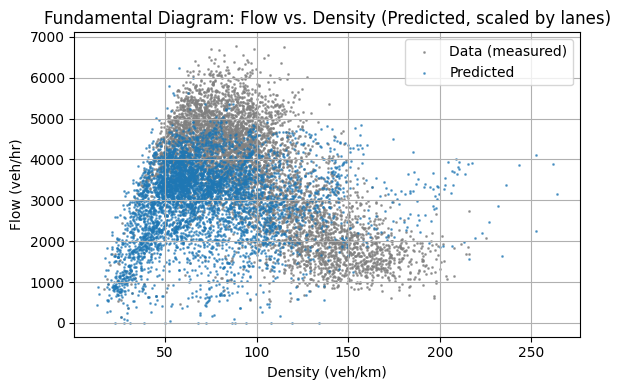

In [11]:
import matplotlib.pyplot as plt

# # Collect scaled predictions across all segments
all_rho_pred = rho_pred_array

print(all_rho_pred.shape)
all_v_pred = v_pred_array
all_q_pred = all_rho_pred * all_v_pred


# Stack predictions
all_rho_pred = np.hstack(all_rho_pred)
all_q_pred = np.hstack(all_q_pred)
all_v_pred = np.hstack(all_v_pred)

assert np.all(v_pred_array[0,:] == v_hat[0,1:-1])
assert np.all(v_pred_array[0,:] == v_hat[0,1:-1])
# Plot
plt.figure(figsize=(6, 4))
plt.scatter(rho_hat, q_hat, color="gray", alpha=0.7, s=1, label="Data (measured)")
plt.scatter(all_rho_pred, all_q_pred, alpha=0.6, s=1, label="Predicted")
plt.xlabel("Density (veh/km)")
plt.ylabel("Flow (veh/hr)")
plt.title("Fundamental Diagram: Flow vs. Density (Predicted, scaled by lanes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

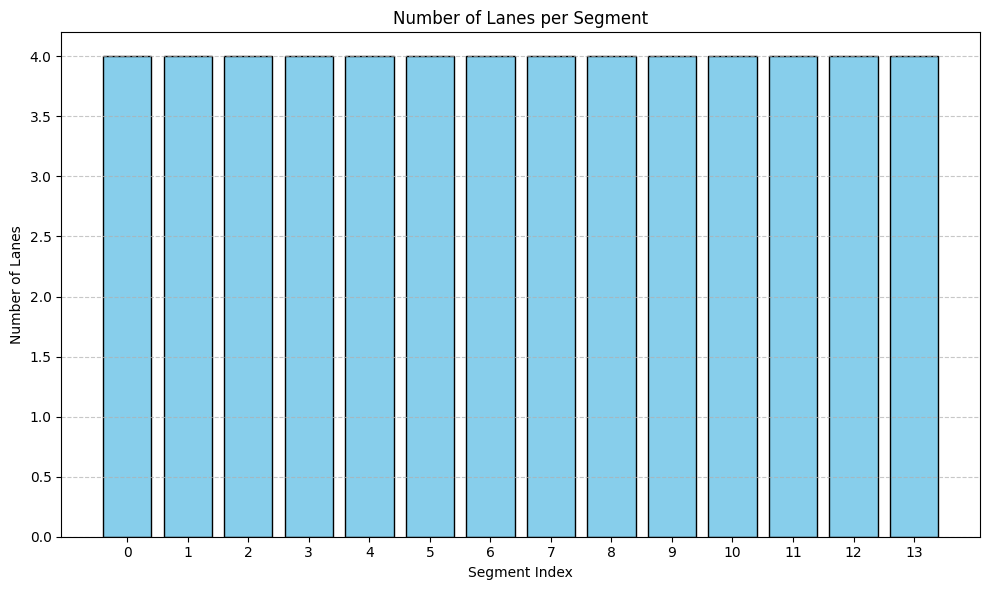

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(
    np.arange(len(num_lanes_array)), num_lanes_array, color="skyblue", edgecolor="black"
)

plt.xlabel("Segment Index")
plt.ylabel("Number of Lanes")
plt.title("Number of Lanes per Segment")
plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

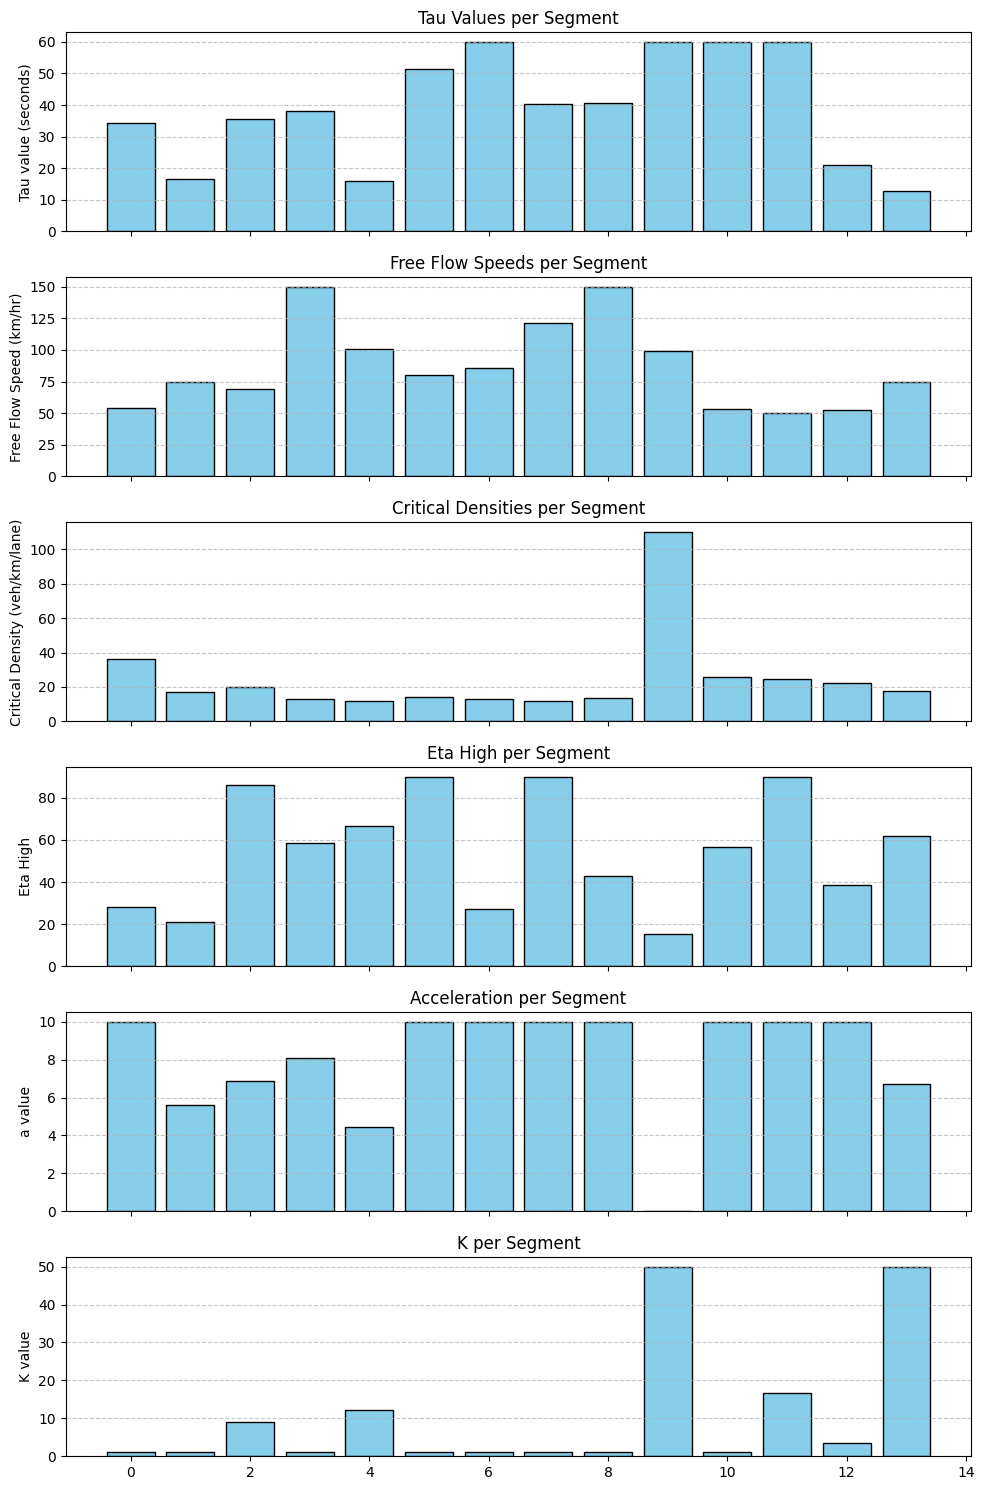

In [13]:
# Plot parameters in bar chart, show default value
fig, axes = plt.subplots(6, 1, figsize=(10, 15), sharex=True)
axes[0].bar(
    np.arange(len(tau_array)), tau_array*3600, color="skyblue", edgecolor="black"
)

axes[0].set_ylabel("Tau value (seconds)")
axes[0].set_title("Tau Values per Segment")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

axes[1].bar(
    np.arange(len(v_free_array)), v_free_array, color="skyblue", edgecolor="black"
)
axes[1].set_ylabel("Free Flow Speed (km/hr)")
axes[1].set_title("Free Flow Speeds per Segment")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

axes[2].bar(
    np.arange(len(rho_crit_array)), rho_crit_array, color="skyblue", edgecolor="black"
)
axes[2].set_ylabel("Critical Density (veh/km/lane)")
axes[2].set_title("Critical Densities per Segment")
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

axes[3].bar(
    np.arange(len(eta_high_array)), eta_high_array, color="skyblue", edgecolor="black"
)
axes[3].set_ylabel("Eta High")
axes[3].set_title("Eta High per Segment")
axes[3].grid(axis="y", linestyle="--", alpha=0.7)

axes[4].bar(
    np.arange(len(a_array)), a_array, color="skyblue", edgecolor="black"
)
axes[4].set_ylabel("a value")
axes[4].set_title("Acceleration per Segment")
axes[4].grid(axis="y", linestyle="--", alpha=0.7)

axes[5].bar(
    np.arange(len(K_array)), K_array, color="skyblue", edgecolor="black"
)
axes[5].set_ylabel("K value")
axes[5].set_title("K per Segment")
axes[5].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

In [14]:
if include_ramping:
    plt.figure(figsize=(10, 6))
    plt.bar(
        np.arange(len(r_inflow_array)), r_inflow_array, color="skyblue", edgecolor="black"
    )

    plt.xlabel("Segment Index")
    plt.ylabel("Inflow")
    plt.title("Inflow per Segment")
    plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()

In [15]:
if include_ramping:
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(beta_array)), beta_array, color="skyblue", edgecolor="black")

    plt.xlabel("Segment Index")
    plt.ylabel("Inflow")
    plt.title("Beta per Segment")
    plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()

In [16]:
print(all_v_pred.shape)
q_array = rho_pred_array * v_pred_array
print("rho mape", mape(rho_hat[:, 1:-1], rho_pred_array))
print("q mape", mape(q_hat[:, 1:-1], q_array))
print("v mape", mape(v_hat[:, 1:-1], v_pred_array))
print("----------------")
print("rho rmse", rmse(rho_hat[:, 1:-1], rho_pred_array))
print("q rmse", rmse(q_hat[:, 1:-1], q_array))
print("v rmse", rmse(v_hat[:, 1:-1], v_pred_array))

(5040,)
rho mape 33.632000742720784
q mape 38.173039193665154
v mape 66.25886509706076
----------------
rho rmse 46.04654038415684
q rmse 1453.67902015161
v rmse 20.397829522572795


In [17]:
print("Simulating with calibrated parameters...")

# Scale densities per lane for simulation
scaled_rho_hat = rho_hat[:, 1:-1] / np.array(num_lanes_array)


# if smoothing boundary conditions
downstream_density = smooth_inflow(rho_hat[:, -1]) / num_lanes_array[-1]
data_inflow = smooth_inflow(q_hat[:, 0])
# downstream_density = rho_hat[:, -1] / num_lanes_array[-1]
# data_inflow = q_hat[:, 0]
# print(downstream_density[250:270])
# print(rho_hat[250:270, -1])

print(np.where(scaled_rho_hat < 0))
# Sim requires tuple of initial conditions: density, velocity, inflow, and queue
init_traffic_state = (scaled_rho_hat[0, :], v_hat[0, 1:-1], data_inflow[0], 0)
print(RESULTS_DIR)
params = METANET_Params(path=RESULTS_DIR, num_segments=num_calibrated_segments).get_params()
rho_sim, v_sim, _, tts_sim = run_metanet_sim(
    T, 
    l, 
    init_traffic_state,
    data_inflow,
    downstream_density,
    params,
    vsl_speeds=None,
    lanes={i: num_lanes_array[i] for i in range(num_calibrated_segments)},
    plotting=True,
    real_data=True
)

print(rho_pred_array[230:270, -1])
print(rho_sim[230:270, -1] * 4)

Simulating with calibrated parameters...
(array([], dtype=int64), array([], dtype=int64))
calibration_results
360 14
[ 55.73547214  58.69580895  59.15621565  56.21490477  55.23667828
  58.64539736  60.4970187   59.12272257  59.12487055  60.30496934
  60.05297461  60.66034023  64.87093695  67.69888208  67.09579893
  67.77861797  73.34058497  78.69894631  78.35112191  78.36560918
  81.30583504  88.36149006  94.19834982  96.57588853  99.87814536
 107.00830775 119.30172964 134.1852141  144.86391921 140.52144063
 123.44442332 108.58948769 100.61575267  96.13502239  95.45601337
  97.08821825  96.0472445   93.13176628  91.05832597  88.59133657]
[ 55.73547206  58.69580895  59.15621603  56.21490498  55.23667805
  58.64539726  60.49701908  59.12272271  59.12487028  60.30496943
  60.05297509  60.66034021  64.87093644  67.69888219  67.09579947
  67.77861788  73.34058412  78.698946    78.3511222   78.3656091
  81.30583402  88.36148863  94.19834873  96.57588698  99.87814261
 107.008303   119.3017224

In [18]:
good_params = METANET_Params(path=RESULTS_DIR, num_segments=num_calibrated_segments).get_params()
bad_params = METANET_Params(path='calibration_results', num_segments=num_calibrated_segments).get_params()
#check if params are different
print(bad_params['r'])
print(good_params['r'])
for key in bad_params:
    if isinstance(bad_params[key], dict):
        for subkey in bad_params[key]:
            if not np.array_equal(bad_params[key][subkey], good_params[key][subkey]):
                print(f"Parameter {key}[{subkey}] differs between bad and good params.")
    else:
        if not np.array_equal(bad_params[key], good_params[key]):
            print(f"Parameter {key} differs between bad and good params.")


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 225.06999625000026


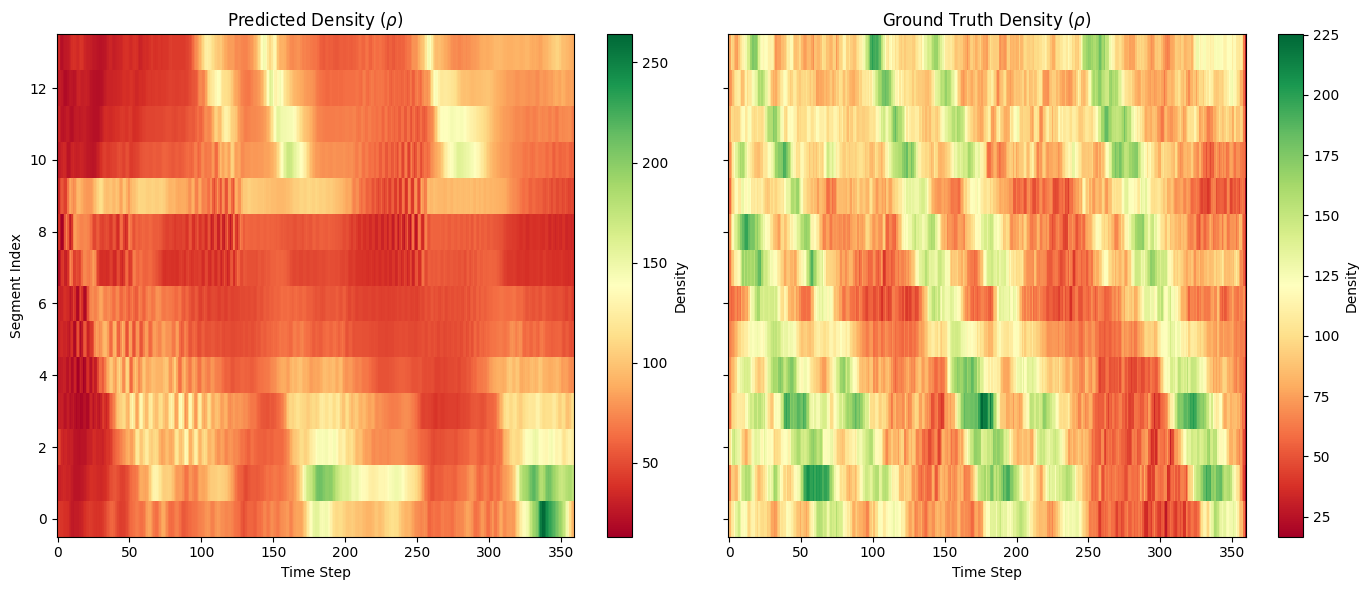

In [19]:
rho_plot_pred = rho_pred_array
rho_plot_true = rho_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(
    rho_plot_pred.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Segment Index")
axes[0].set_title("Predicted Density ($\\rho$)")
fig.colorbar(im0, ax=axes[0], label="Density")

# --- Ground Truth ---
im1 = axes[1].imshow(
    rho_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[1].set_xlabel("Time Step")
axes[1].set_title("Ground Truth Density ($\\rho$)")
fig.colorbar(im1, ax=axes[1], label="Density")

plt.tight_layout()
plt.show()

[15.60562109 22.63969379 14.53123911 33.0528382  44.74894381 40.31822336
 36.43426698 50.4408325  24.55019846 12.00645115  5.34702448 21.88636564
 40.55200066 44.41112619]
[30.68682024 41.19168953 39.38559905 64.86514058 72.38312555 46.73336433
 49.82489233 14.46139173 65.01227557 11.16219049  3.88752461 26.46217003
 34.35984234 76.46342477]
Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 102.5494591064967


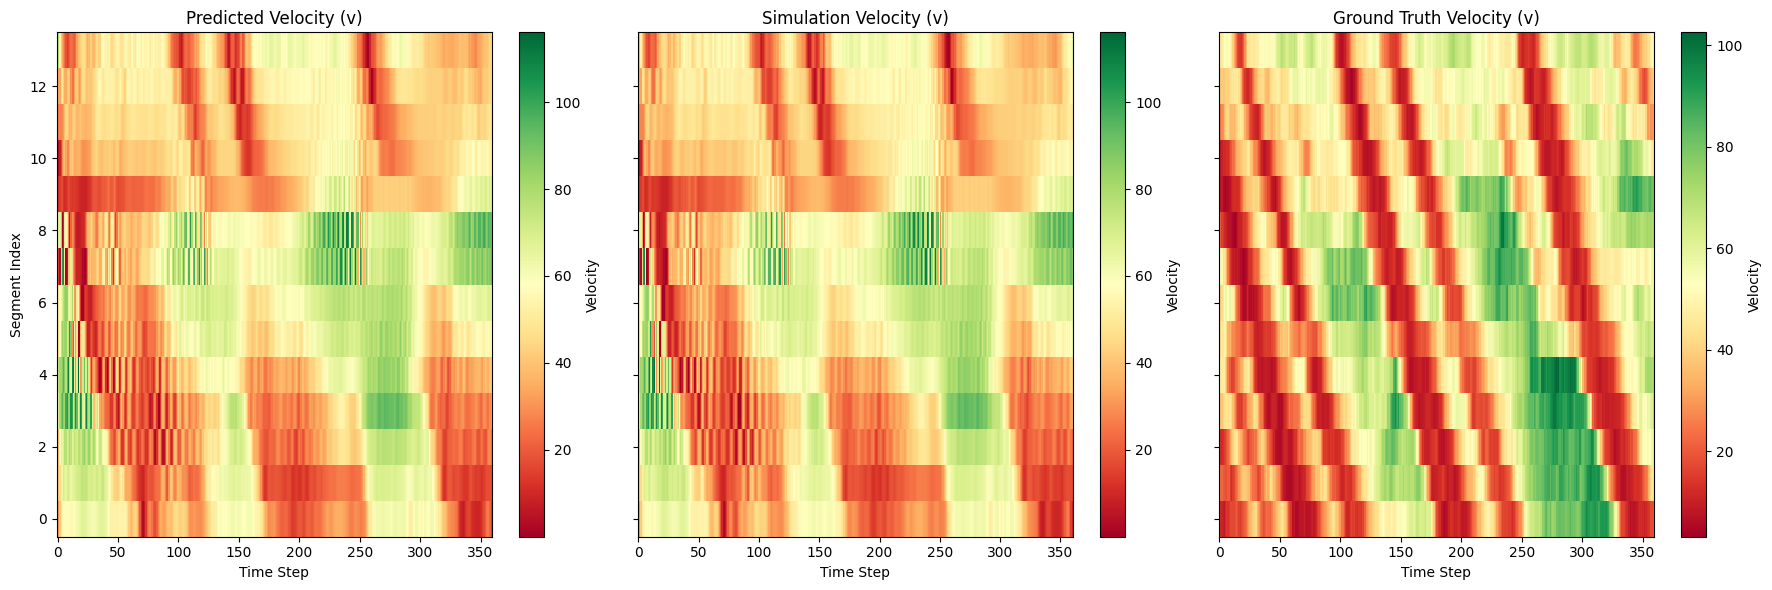

In [20]:
print(v_pred_array[0, :])
print(v_pred_array[1, :])
v_plot_pred = v_pred_array
v_plot_true = v_hat[:, 1:-1]

print("Pred shape:", v_plot_pred.shape)
print("True shape:", v_plot_true.shape)
print("Max true density:", np.max(v_plot_true))

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(
    v_plot_pred.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Segment Index")
axes[0].set_title("Predicted Velocity (v)")
fig.colorbar(im0, ax=axes[0], label="Velocity")

# --- Simulation ---
im1 = axes[1].imshow(
    v_sim.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[1].set_xlabel("Time Step")
axes[1].set_title("Simulation Velocity (v)")
fig.colorbar(im1, ax=axes[1], label="Velocity")


# --- Ground Truth ---
im2 = axes[2].imshow(
    v_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[2].set_xlabel("Time Step")
axes[2].set_title("Ground Truth Velocity (v)")
fig.colorbar(im2, ax=axes[2], label="Velocity")

plt.tight_layout()
plt.show()

In [21]:
print(downstream_density[249:270])
print(smooth_inflow(rho_hat[249:270, -1])/num_lanes_array[-1])

print(np.max(v_plot_pred))

[34.72499897 35.76749919 34.47124909 33.52374881 33.35999866 32.78749881
 31.41124906 30.16374934 27.24624944 25.07749916 23.15874919 20.3337495
 17.85124931 17.77124891 19.70624881 19.43874894 18.61624909 19.09749912
 18.80624888 19.02124894 20.01874916]
[36.55249925 35.76749919 34.47124909 33.52374881 33.35999866 32.78749881
 31.41124906 30.16374934 27.24624944 25.07749916 23.15874919 20.3337495
 17.85124931 17.77124891 19.70624881 19.43874894 18.61624909 19.09749912
 18.80624888 19.02124894 20.01874916]
116.06404765679082


/var/folders/kl/txwf6c7d73v3xczbyqm3trhw0000gn/T/ipykernel_67567/398615056.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


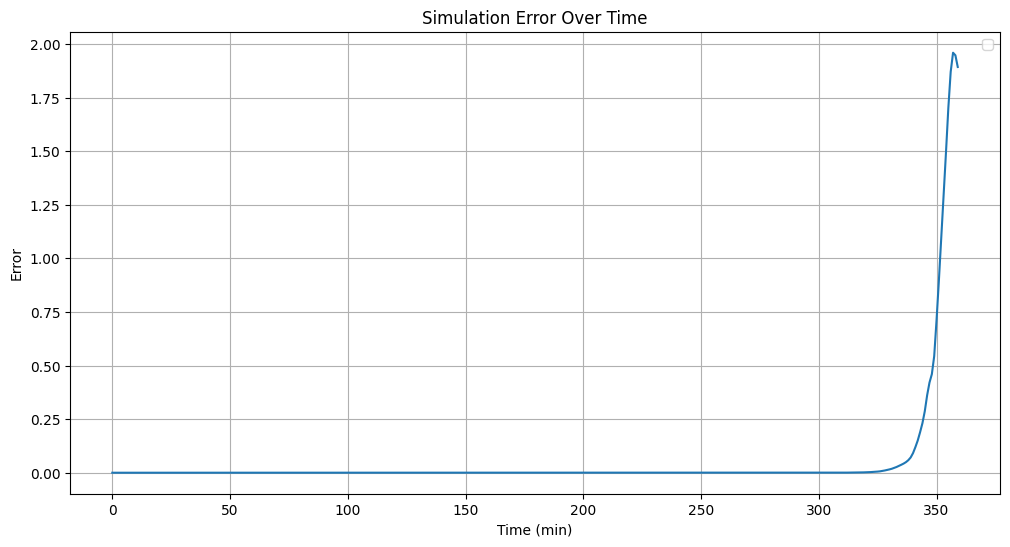

In [22]:
# plot error over time between prediction and simulation
plt.figure(figsize=(12, 6))
plt.plot(np.abs(v_plot_pred - v_sim[0:-1, :]).mean(axis=1))
plt.xlabel('Time (min)')
plt.ylabel('Error')
plt.title('Simulation Error Over Time')
plt.legend()
plt.grid()
plt.savefig(RESULTS_DIR + '/error_propogate_lanes_ramping.png')
plt.show()

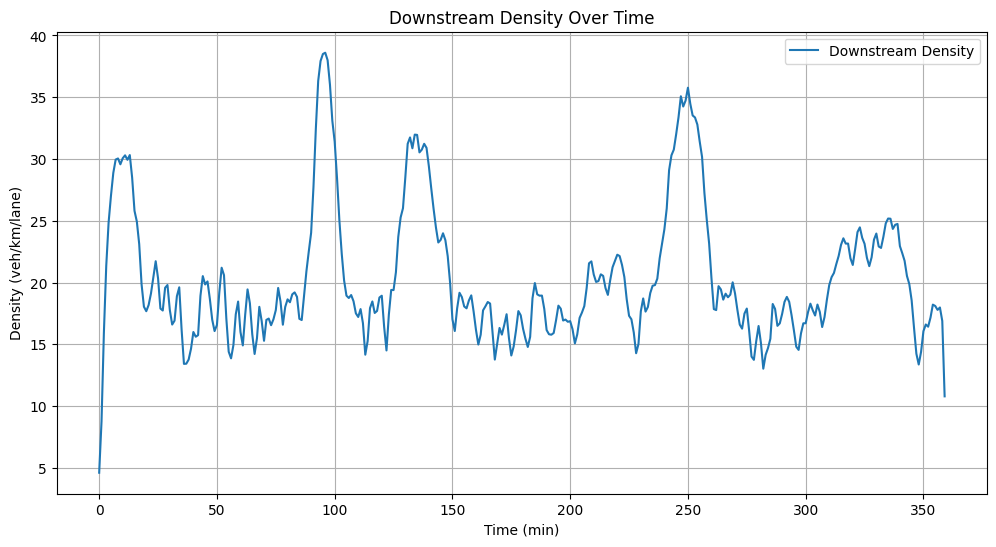

In [23]:
#plot downstream density over time and inflow over time
plt.figure(figsize=(12, 6))
plt.plot(downstream_density, label='Downstream Density')
plt.xlabel('Time (min)')
plt.ylabel('Density (veh/km/lane)')
plt.title('Downstream Density Over Time')
plt.legend()
plt.grid()
plt.show()



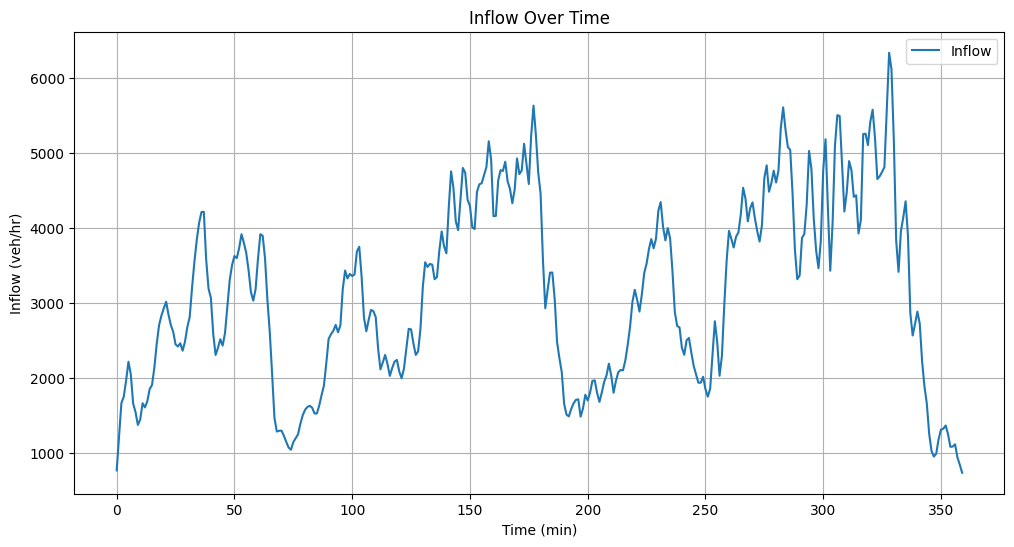

In [24]:
# Plot inflow over time
plt.figure(figsize=(12, 6))
plt.plot(data_inflow, label='Inflow')
plt.xlabel('Time (min)')
plt.ylabel('Inflow (veh/hr)')
plt.title('Inflow Over Time')
plt.legend()
plt.grid()
plt.show()

Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 6749.992799999934


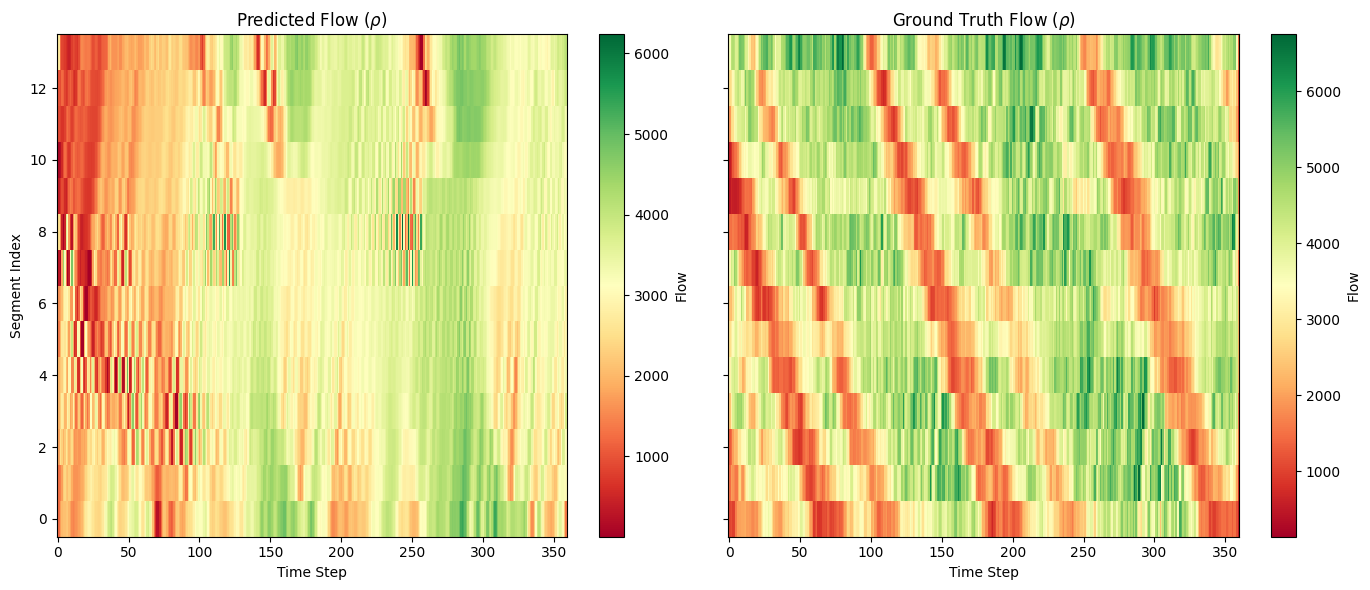

In [25]:
rho_plot_pred = rho_pred_array * v_pred_array
rho_plot_true = q_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(
    rho_plot_pred.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Segment Index")
axes[0].set_title("Predicted Flow ($\\rho$)")
fig.colorbar(im0, ax=axes[0], label="Flow")

# --- Ground Truth ---
im1 = axes[1].imshow(
    rho_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
)
axes[1].set_xlabel("Time Step")
axes[1].set_title("Ground Truth Flow ($\\rho$)")
fig.colorbar(im1, ax=axes[1], label="Flow")

plt.tight_layout()
plt.show()

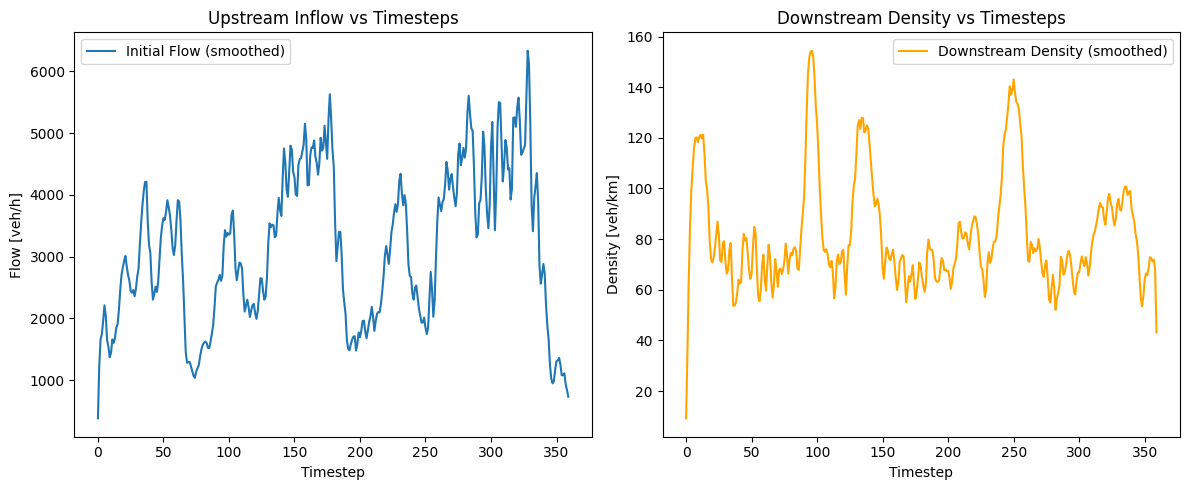

In [26]:
import numpy as np
import matplotlib.pyplot as plt


def smooth_inflow(inflow, window_size=2):
    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(
        lambda m: np.convolve(m, kernel, mode="same"), axis=0, arr=inflow
    )
    return smoothed


# Example input arrays (replace with your real q_hat and rho_hat)
# timesteps = 100
# q_hat = np.random.uniform(500, 1000, size=(timesteps, 5))   # flow [veh/h]
# rho_hat = np.random.uniform(10, 50, size=(timesteps, 5))    # density [veh/km]

# Apply smoothing
initial_flow = smooth_inflow(q_hat[:, 0:1])  # upstream inflow
downstream_density = smooth_inflow(rho_hat[:, -1:])  # downstream density

# Plotting
plt.figure(figsize=(12, 5))

# Flow vs timesteps
plt.subplot(1, 2, 1)
plt.plot(initial_flow, label="Initial Flow (smoothed)")
plt.xlabel("Timestep")
plt.ylabel("Flow [veh/h]")
plt.title("Upstream Inflow vs Timesteps")
plt.legend()

# Density vs timesteps
plt.subplot(1, 2, 2)
plt.plot(downstream_density, color="orange", label="Downstream Density (smoothed)")
plt.xlabel("Timestep")
plt.ylabel("Density [veh/km]")
plt.title("Downstream Density vs Timesteps")
plt.legend()

plt.tight_layout()
plt.show()

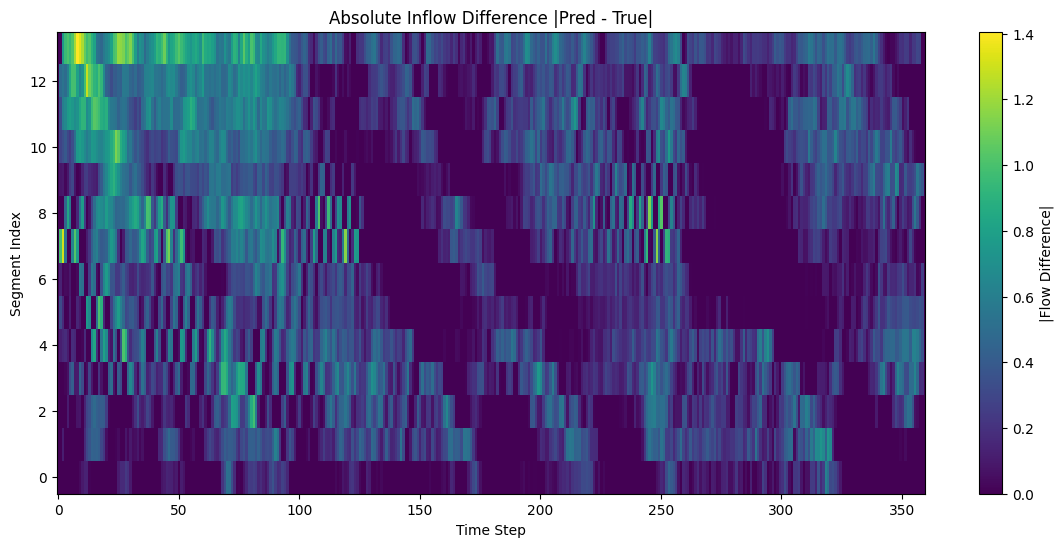

In [27]:
def get_velocity_heatmap(v_hat, v_pred, q_hat, q_pred, rho_hat, rho_pred):
    shortened_v_hat = v_hat[:, 1:-1]
    shortened_rho_hat = rho_hat[:, 1:-1]
    shortened_q_hat = q_hat[:, 1:-1]
    # Determine some set of 3 scalars for each of q, rho, v to make a unified map
    v_diff = (shortened_v_hat - v_pred) / np.max(shortened_v_hat)
    rho_diff = (shortened_rho_hat - rho_pred) / np.max(shortened_rho_hat)
    q_diff = (shortened_q_hat - q_pred) / np.max(shortened_q_hat)

    diff = v_diff + rho_diff + q_diff
    fig, ax = plt.subplots(figsize=(14, 6))

    im = ax.imshow(
        diff.T,
        aspect="auto",
        origin="lower",
        cmap="viridis",
        interpolation="none",
        vmin=0,
    )
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Segment Index")
    ax.set_title("Absolute Inflow Difference |Pred - True|")
    fig.colorbar(im, ax=ax, label="|Flow Difference|")
    plt.show()


get_velocity_heatmap(v_hat, v_pred_array, q_hat, q_array, rho_hat, rho_pred_array)